In [20]:
# %% [markdown]
# # 1. Install Dependencies and Setup

# %%
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


In [21]:

# # Avoid OOM errors by setting GPU Memory Consumption Growth
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus: 
#     tf.config.experimental.set_memory_growth(gpu, True)
# tf.config.list_physical_devices('GPU')


In [22]:

# %% [markdown]
# # 2. Remove Dodgy Images

# %%
import cv2
import imghdr

data_dir = 'dataset'  # Update path to your dataset folder
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir): 
    class_path = os.path.join(data_dir, image_class)
    if not os.path.isdir(class_path):
        continue
    
    for image in os.listdir(class_path):
        image_path = os.path.join(class_path, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print(f'Image not in ext list {image_path}')
                os.remove(image_path)
        except Exception as e: 
            print(f'Issue with image {image_path}')


Issue with image dataset/Train/Real
Issue with image dataset/Train/AI


In [23]:

# %% [markdown]
# # 3. Data Augmentation and Loading

# %%
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_data = train_gen.flow_from_directory(
    data_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_data = train_gen.flow_from_directory(
    data_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 800 images belonging to 2 classes.
Found 199 images belonging to 2 classes.


In [24]:

# %% [markdown]
# # 4. Build Transfer Learning Model

# %%
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,104,833 (88.14 MB)

 Trainable params: 8,389,633 (32.00 MB)

 Non-trainable params: 14,715,200 (56.13 MB)

In [25]:

# %% [markdown]
# # 5. Train Model with Learning Rate Scheduling

# %%
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[early_stopping, lr_scheduler]
)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 105s 4s/step - accuracy: 0.5383 - loss: 0.9599 - val_accuracy: 0.1960 - val_loss: 2.2285 - learning_rate: 1.0000e-04
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 117s 5s/step - accuracy: 0.6089 - loss: 0.8232 - val_accuracy: 0.1910 - val_loss: 1.9293 - learning_rate: 1.0000e-04
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 116s 5s/step - accuracy: 0.6625 - loss: 0.7030 - val_accuracy: 0.2261 - val_loss: 1.3509 - learning_rate: 1.0000e-04
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 124s 5s/step - accuracy: 0.5806 - loss: 0.7651 - val_accuracy: 0.2211 - val_loss: 1.5050 - learning_rate: 1.0000e-04
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 131s 5s/step - accuracy: 0.7135 - loss: 0.6454 - val_accuracy: 0.2161 - val_loss: 1.6586 - learning_rate: 1.0000e-04
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 125s 5s/step - accuracy: 0.6784 - loss: 0.6248 - val_accuracy: 0.4724 - val_loss: 0.9501 - learning_rate: 1.0000e-04
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 116s 5s/step - accuracy: 0.6687 

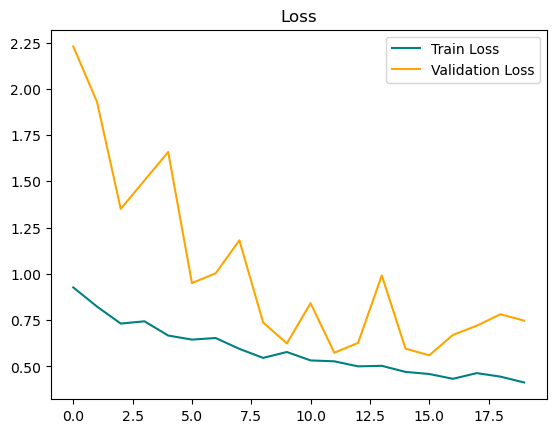

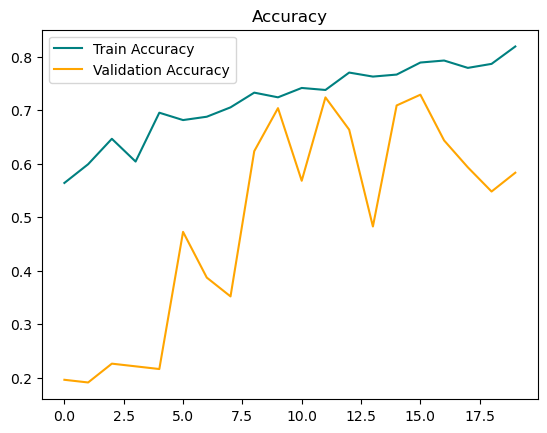

In [26]:

# %% [markdown]
# # 6. Plot Performance

# %%
# Loss Plot
plt.figure()
plt.plot(history.history['loss'], label='Train Loss', color='teal')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss')
plt.legend()
plt.show()

# Accuracy Plot
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy', color='teal')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Accuracy')
plt.legend()
plt.show()


In [10]:
# %% [markdown]
# # 7. Evaluate Model (Flat Folder)

# %%
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os

# Path to test folder
test_dir = 'dataset/Test'  # Update to your test folder path

# Get all image file paths
image_files = [os.path.join(test_dir, img) for img in os.listdir(test_dir) if img.lower().endswith(('jpeg', 'jpg', 'png', 'bmp'))]

# Create a DataFrame for the test images (use dummy labels, as labels are not used during evaluation)
test_df = pd.DataFrame({
    'filename': image_files,
    'class': [0] * len(image_files)  # Dummy labels
})

# Initialize ImageDataGenerator
test_gen = ImageDataGenerator(rescale=1.0/255.0)

# Create test data generator from DataFrame
test_data = test_gen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',  # Dummy column; will not be used during evaluation
    target_size=(256, 256),
    batch_size=32,
    class_mode=None,  # No labels are needed for prediction
    shuffle=False
)

# Evaluate the model
predictions = model.predict(test_data, verbose=1)
print("Predictions:")
print(predictions)

Found 198 validated image filenames.
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step
Predictions:
[[0.80969065]
 [0.44514725]
 [0.4642101 ]
 [0.25217757]
 [0.55007446]
 [0.3336952 ]
 [0.7665039 ]
 [0.3513097 ]
 [0.5046022 ]
 [0.08294753]
 [0.2907115 ]
 [0.4486722 ]
 [0.4649708 ]
 [0.4793809 ]
 [0.38224658]
 [0.40817162]
 [0.4155414 ]
 [0.65743446]
 [0.49277997]
 [0.17940366]
 [0.17209469]
 [0.50559324]
 [0.29149187]
 [0.5529778 ]
 [0.5074862 ]
 [0.3435685 ]
 [0.5077587 ]
 [0.47454768]
 [0.41724718]
 [0.50609887]
 [0.35398832]
 [0.48269072]
 [0.50355244]
 [0.39257437]
 [0.37512404]
 [0.57072735]
 [0.36545813]
 [0.2581241 ]
 [0.07337525]
 [0.6605705 ]
 [0.40831497]
 [0.34025377]
 [0.4654173 ]
 [0.4423074 ]
 [0.19685538]
 [0.32417116]
 [0.6330091 ]
 [0.37636033]
 [0.54821485]
 [0.32655933]
 [0.26537606]
 [0.08684204]
 [0.2864241 ]
 [0.20681515]
 [0.3012271 ]
 [0.66040325]
 [0.03420977]
 [0.46167967]
 [0.34310097]
 [0.60410243]
 [0.37731224]
 [0.63535583]
 [0.7748841 ]
 [0.82903165]
 [0.41756245]
 [0

7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step
Confusion Matrix:
[[150  48]
 [  0   0]]


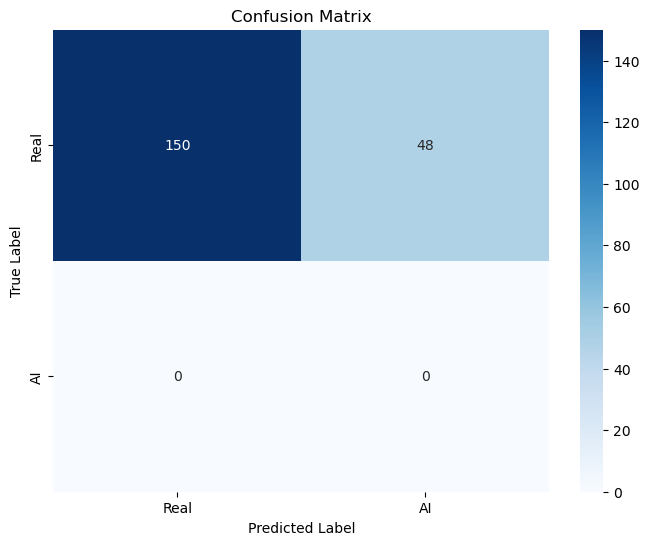


Classification Report:
              precision    recall  f1-score   support

        Real       1.00      0.76      0.86       198
          AI       0.00      0.00      0.00         0

    accuracy                           0.76       198
   macro avg       0.50      0.38      0.43       198
weighted avg       1.00      0.76      0.86       198



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
# %% [markdown]
# # 8. Confusion Matrix and Classification Report

# %%
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict labels for the test set
y_pred = (model.predict(test_data) > 0.5).astype(int).flatten()

# Since test_data does not provide labels, define the true labels manually
# Replace this array with the actual labels if available
y_true = test_df['class'].values.astype(int)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'AI'], yticklabels=['Real', 'AI'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Real', 'AI']))

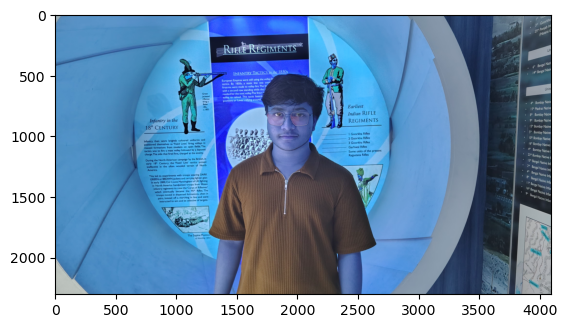

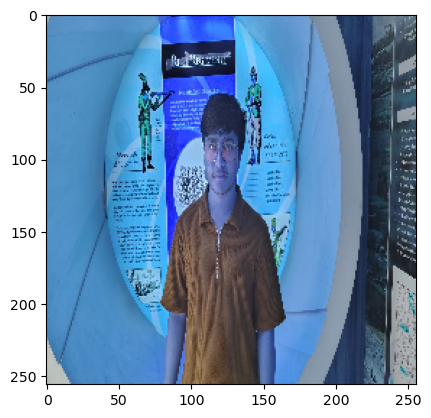

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
Predicted class is Real


In [28]:

# Load and preprocess the image
img = cv2.imread('1.jpeg')
plt.imshow(img)
plt.show()

resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

# Predict the class
yhat = model.predict(np.expand_dims(resize / 255, 0))
if yhat > 0.5: 
    print(f'Predicted class is AI')
else:
    print(f'Predicted class is Real')

In [29]:

# %% [markdown]
# # 9. Save the Model

# %%
model.save('models/real_vs_ai_classifier_v2.h5')
print("Model saved successfully.")

Model saved successfully.


In [30]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import BinaryCrossentropy

# Define a compatible loss function
def custom_loss(y_true, y_pred):
    return BinaryCrossentropy(reduction=tf.keras.losses.Reduction.SUM)(y_true, y_pred)

# Load the model with custom loss
model = load_model('models/real_vs_ai_classifier_v2.h5', custom_objects={'custom_loss': custom_loss})

# Path to the test folder
test_folder = 'dataset/Test'  # Update this to the path of your test folder
output_csv = 'predictions.csv'

# Initialize a list to store the predictions
results = []

# Iterate over all images in the test folder in sorted order
for idx, image_file in enumerate(sorted(os.listdir(test_folder))):  # Sort ensures ordered processing
    # Construct the full image path
    image_path = os.path.join(test_folder, image_file)
    
    # Load and preprocess the image
    try:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Unable to read image: {image_file}")
            continue
        
        # Resize image to the input size of the model and normalize
        resize = tf.image.resize(img, (256, 256))  
        img_array = resize.numpy() / 255.0
        
        # Predict the class
        yhat = model.predict(np.expand_dims(img_array, 0))[0][0]  # Get the prediction score
        
        # Determine the label
        label = 'AI' if yhat > 0.5 else 'Real'
        
        # Append the result, using an ordered ID
        results.append({'Id': f'image_{idx + 1}', 'Label': label})
    
    except Exception as e:
        print(f"Error processing image {image_file}: {e}")

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to a CSV file
results_df.to_csv(output_csv, index=False)

print(f"Predictions saved to {output_csv}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 